In [ ]:
#| default_exp _components.mono_dense_layer

# MonoLayer internals

> Implementation of the MonoDense layer

## Imports

In [ ]:
#| export
#| hide

from contextlib import contextmanager
from datetime import datetime
from functools import lru_cache
from typing import *

import tensorflow as tf
import numpy as np

from numpy.typing import ArrayLike, NDArray
from tensorflow.keras.layers import Dense
from tensorflow.types.experimental import TensorLike

In [ ]:
#| hide

from pathlib import Path
from os import environ

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import pytest
import seaborn as sns
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [ ]:
#| hide

environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

## Monotonic Dense Layer


### Actvation Functions

We use $\breve{\mathcal{A}}$ to denote the set of all zero-centred, monotonically increasing, convex, lower-bounded functions.

Let $\breve{\rho} \in \breve{\mathcal{A}}$. Then
\begin{align}\label{eq:activation_concave}
    \hat{\rho}(x) & = -\breve{\rho}(-x) \\
    \label{eq:activation_saturated}
    \tilde{\rho}(x) & = \begin{cases}
      \breve{\rho}(x+1)-\breve{\rho}(1) & \text{if }x < 0\\
      \hat{\rho}(x-1)+\breve{\rho}(1) & \text{otherwise}
    \end{cases} 
\end{align}
 
 In the code below, the following names are used for denotation of the above functions:
 
 - `convex_activation` denotes $\breve{\rho}$,
 
 - `concave_activation` denotes $\hat{\rho}$, and
 
 - `saturated_activation` denotes $\tilde{\rho}$. 
 

In [ ]:
# | export


def get_saturated_activation(
    convex_activation: Callable[[TensorLike], TensorLike],
    concave_activation: Callable[[TensorLike], TensorLike],
    a: float = 1.0,
    c: float = 1.0,
) -> Callable[[TensorLike], TensorLike]:
    @tf.function
    def saturated_activation(
        x: TensorLike,
        convex_activation: Callable[[TensorLike], TensorLike] = convex_activation,
        concave_activation: Callable[[TensorLike], TensorLike] = concave_activation,
        a: float = a,
        c: float = c,
    ) -> TensorLike:
        cc = convex_activation(tf.ones_like(x) * c)
        ccc = concave_activation(-tf.ones_like(x) * c)
        return a * tf.where(
            x <= 0,
            convex_activation(x + c) - cc,
            concave_activation(x - c) + cc,
        )

    return saturated_activation # type: ignore

@lru_cache
def get_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None
) -> Tuple[
    Callable[[TensorLike], TensorLike],
    Callable[[TensorLike], TensorLike],
    Callable[[TensorLike], TensorLike],
]:
    convex_activation = tf.keras.activations.get(
        activation.lower() if isinstance(activation, str) else activation
    )

    @tf.function
    def concave_activation(x: TensorLike) -> TensorLike:
        return -convex_activation(-x)

    saturated_activation = get_saturated_activation(
        convex_activation, concave_activation
    )
    return convex_activation, concave_activation, saturated_activation

In [ ]:
#| hide

for activation in [None, "relu", tf.keras.activations.elu]:
    f, g, h = get_activation_functions(activation)
    hasattr(f, "__call__")
    hasattr(g, "__call__")
    hasattr(h, "__call__")

In [ ]:
#| hide

def plot_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    *,
    font_size: int = 20,
    save_pdf: bool = False,
    save_path: Union[Path, str] = "plots",
    linestyle="--", 
    alpha=0.7,
    linewidth=4.0
) -> None:
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    plt.rcParams["figure.figsize"] = (6, 4)

    x = np.arange(-3.5, 3.5, 0.1)
    plot_kwargs = dict(linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    plt.plot(x, convex_activation(x), label=r"$\breve{\rho}(x)$", **plot_kwargs)
    plt.plot(x, concave_activation(x), label=r"$\hat{\rho}(x)$", **plot_kwargs)
    plt.plot(x, saturated_activation(x), label=r"$\tilde{\rho}(x)$", **plot_kwargs)
    plt.legend()

    title = f"{activation.__name__ if hasattr(activation, '__name__') else activation}-based activations"
    plt.title(title)
    if save_pdf:
        for file_format in ["pdf", "png"]:
            path = Path(save_path) / (title.replace(" ", "_") + f".{file_format}")
            path.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(path, format=file_format)
            print(f"Saved figure to: {path}")

    plt.show()

Saved figure to: plots/linear-based_activations.pdf
Saved figure to: plots/linear-based_activations.png


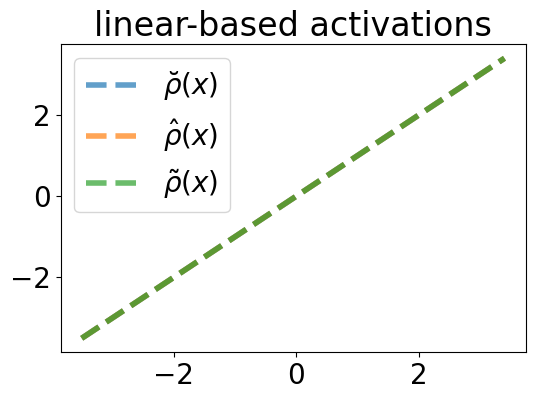

Saved figure to: plots/ReLU-based_activations.pdf
Saved figure to: plots/ReLU-based_activations.png


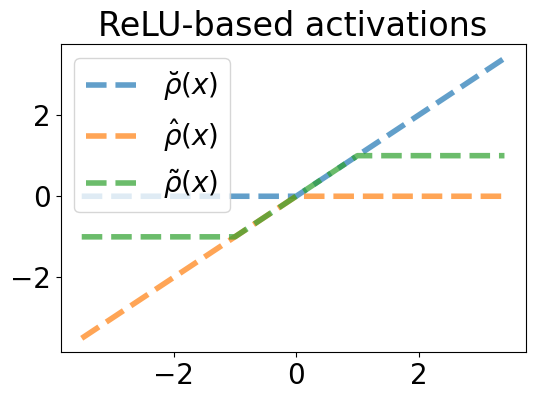

Saved figure to: plots/ELU-based_activations.pdf
Saved figure to: plots/ELU-based_activations.png


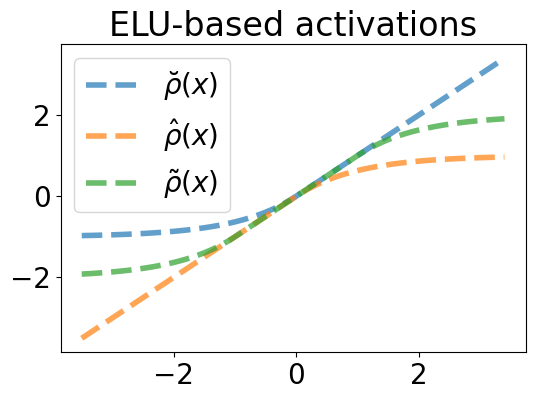

Saved figure to: plots/SELU-based_activations.pdf
Saved figure to: plots/SELU-based_activations.png


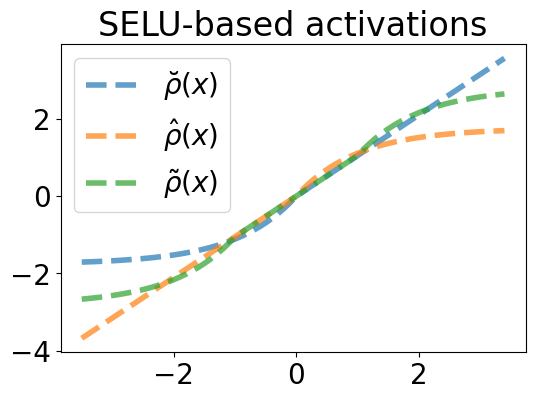

In [ ]:
#| hide

for activation in ["linear", "ReLU", "ELU", "SELU"]:
    plot_activation_functions(activation, save_pdf=True)

In [ ]:
# | export


@tf.function
def apply_activations(
    x: TensorLike,
    *,
    units: int,
    convex_activation: Callable[[TensorLike], TensorLike],
    concave_activation: Callable[[TensorLike], TensorLike],
    saturated_activation: Callable[[TensorLike], TensorLike],
    is_convex: bool = False,
    is_concave: bool = False,
    activation_weights: Tuple[float, float, float] = (7.0, 7.0, 2.0),
) -> TensorLike:
    if convex_activation is None:
        return x

    elif is_convex:
        normalized_activation_weights = np.array([1.0, 0.0, 0.0])
    elif is_concave:
        normalized_activation_weights = np.array([0.0, 1.0, 0.0])
    else:
        if len(activation_weights) != 3:
            raise ValueError(f"activation_weights={activation_weights}")
        if (np.array(activation_weights) < 0).any():
            raise ValueError(f"activation_weights={activation_weights}")
        normalized_activation_weights = np.array(activation_weights) / sum(
            activation_weights
        )

    s_convex = round(normalized_activation_weights[0] * units)
    s_concave = round(normalized_activation_weights[1] * units)
    s_saturated = units - s_convex - s_concave

    x_convex, x_concave, x_saturated = tf.split(
        x, (s_convex, s_concave, s_saturated), axis=-1
    )

    y_convex = convex_activation(x_convex)
    y_concave = concave_activation(x_concave)
    y_saturated = saturated_activation(x_saturated)

    y = tf.concat([y_convex, y_concave, y_saturated], axis=-1)

    return y

In [ ]:
def plot_applied_activation(
    activation: str = "relu",
    *,
    save_pdf: bool = False,
    save_path: Union[Path, str] = "plots",
    font_size: int = 20,
    linestyle="--",
    alpha=0.7,
    linewidth=2.0,
):
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    plt.rcParams["figure.figsize"] = (18, 3)

    x = np.arange(-1.5, 1.5, step=3 / 256)
    h = 3 * np.sin(2 * np.pi * x)

    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)

    y = apply_activations(
        h,
        convex_activation=convex_activation,
        concave_activation=concave_activation,
        saturated_activation=saturated_activation,
        units=x.shape[0],
        activation_weights=(1.0, 1.0, 1.0),
    )

    plot_kwargs = dict(linestyle=linestyle, alpha=alpha, linewidth=linewidth)

    plt.plot(np.arange(x.shape[0]), h, label="$h$", **plot_kwargs)
    plt.plot(np.arange(x.shape[0]), y, label=r"${\rho}(h)$", **plot_kwargs)
    title = (
        "Applying "
        + (activation.__name__ if hasattr(activation, "__name__") else activation)
        + f"-based activations to {x.shape[0]}-dimensional vector"
        + r" $h$"
    )
    plt.title(title)

    plt.legend()

    if save_pdf:
        path = Path(save_path) / (title.replace(" ", "_") + ".pdf")
        path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(path, format="pdf")
    #         print(f"Saved figure to: {path}")

    plt.show()

In [ ]:
for activation in ["linear", "ReLU", "ELU", "SELU"]:
    plot_applied_activation(activation, save_pdf=True)

### Monotonicity indicator


In [ ]:
#| export

def get_monotonicity_indicator(
    monotonicity_indicator: ArrayLike,
    *,
    input_shape: Tuple[int, ...],
    units: int,
) -> TensorLike:
    # convert to tensor if needed and make it broadcastable to the kernel
    monotonicity_indicator = np.array(monotonicity_indicator)
    if len(monotonicity_indicator.shape) < 2:
        monotonicity_indicator = np.reshape(monotonicity_indicator, (-1, 1))
    elif len(monotonicity_indicator.shape) > 2:
        raise ValueError(
            f"monotonicity_indicator has rank greater than 2: {monotonicity_indicator.shape}"
        )

    monotonicity_indicator_broadcasted = np.broadcast_to(
        monotonicity_indicator, shape=(input_shape[-1], units)
    )

    if not np.all(
        (monotonicity_indicator == -1)
        | (monotonicity_indicator == 0)
        | (monotonicity_indicator == 1)
    ):
        raise ValueError(
            f"Each element of monotonicity_indicator must be one of -1, 0, 1, but it is: '{monotonicity_indicator}'"
        )
    return monotonicity_indicator

In [ ]:
input_shape = (13, 2)
units = 3

layer = Dense(units=units)
layer.build(input_shape=input_shape)

for monotonicity_indicator in [
    1,
    [1],
    [1, 1],
    np.ones((2,)),
    np.ones((2, 1)),
    np.ones((2, 3)),
]:
    expected = np.ones((2, 3))
    actual = get_monotonicity_indicator(
        monotonicity_indicator, input_shape=(13, 2), units=3
    )

    # rank is 2
    assert len(actual.shape) == 2
    # it is broadcastable to the kernel shape of (input_shape[-1], units)
    np.testing.assert_array_equal(np.broadcast_to(actual, (2, 3)), expected)


In [ ]:
expected = [[1], [0], [-1]]
actual = get_monotonicity_indicator([1, 0, -1], input_shape=(13, 3), units=4)
np.testing.assert_array_equal(actual, expected)

In [ ]:
with pytest.raises(ValueError) as e:
    get_monotonicity_indicator([0, 1, -1], input_shape=(13, 2), units=3)
assert e.value.args == (
    "operands could not be broadcast together with remapped shapes [original->remapped]: (3,1)  and requested shape (2,3)",
)

In [ ]:
#| export

def apply_monotonicity_indicator_to_kernel(
    kernel: tf.Variable,
    monotonicity_indicator: ArrayLike,
) -> TensorLike:

    # convert to tensor if needed and make it broadcastable to the kernel
    monotonicity_indicator = tf.convert_to_tensor(monotonicity_indicator)

    # absolute value of the kernel
    abs_kernel = tf.abs(kernel)

    # replace original kernel values for positive or negative ones where needed
    xs = tf.where(
        monotonicity_indicator == 1,
        abs_kernel,
        kernel,
    )
    xs = tf.where(monotonicity_indicator == -1, -abs_kernel, xs)

    return xs


@contextmanager
def replace_kernel_using_monotonicity_indicator(
    layer: tf.keras.layers.Dense,
    monotonicity_indicator: TensorLike,
) -> Generator[None, None, None]:
    old_kernel = layer.kernel

    layer.kernel = apply_monotonicity_indicator_to_kernel(
        layer.kernel, monotonicity_indicator
    )
    try:
        yield
    finally:
        layer.kernel = old_kernel
        
replace_kernel_using_monotonicity_indicator.__module__ = "mono_dense_keras"

In [ ]:
def display_kernel(kernel: Union[tf.Variable, np.typing.NDArray[float]]) -> None:
    cm = sns.color_palette("coolwarm_r", as_cmap=True)

    df = pd.DataFrame(kernel)
    
    display(df.style.format("{:.2f}").background_gradient(cmap=cm, vmin=-1e-8, vmax=1e-8))

In [ ]:
tf.keras.utils.set_random_seed(42)

units = 18
input_len = 7

layer = tf.keras.layers.Dense(units=units)

input_shape = (input_len,)
layer.build(input_shape=input_shape)

print("Original kernel:")
display_kernel(layer.kernel)

print("Kernel after applying monotocity indicator 1 for all values:")
monotonicity_indicator = get_monotonicity_indicator(
    1, input_shape=input_shape, units=units
)
with replace_kernel_using_monotonicity_indicator(layer, monotonicity_indicator):
    display_kernel(layer.kernel)

In [ ]:
monotonicity_indicator = [1] * 2 + [-1] * 2 + [0] * (input_shape[0] - 4)
monotonicity_indicator = get_monotonicity_indicator(
    monotonicity_indicator, input_shape=input_shape, units=units
)

print("Monotocity indicator:")
display_kernel(monotonicity_indicator)

print("Kernel after applying the monotocity indicator:")
with replace_kernel_using_monotonicity_indicator(
    layer, monotonicity_indicator
):
    display_kernel(layer.kernel)

### Monotonic Dense Layer

This is an implementation of our Monotonic Dense Unit or Constrained Monotone Fully Connected Layer. The below is the figure from the paper for reference.

In the code, the variable `monotonicity_indicator` corresponds to **t** in the figure and the variable `activation_selector` corresponds to **s**. 

Parameters `convexity_indicator` and `epsilon` are used to calculate `activation_selector` as follows:
- if `convexity_indicator` is  -1 or 1, then `activation_selector` will have all elements 0 or 1, respecively.
- if `convexity_indicator` is `None`, then `epsilon` must have a value between 0 and 1 and corresponds to the percentage of elements of `activation_selector` set to 1.

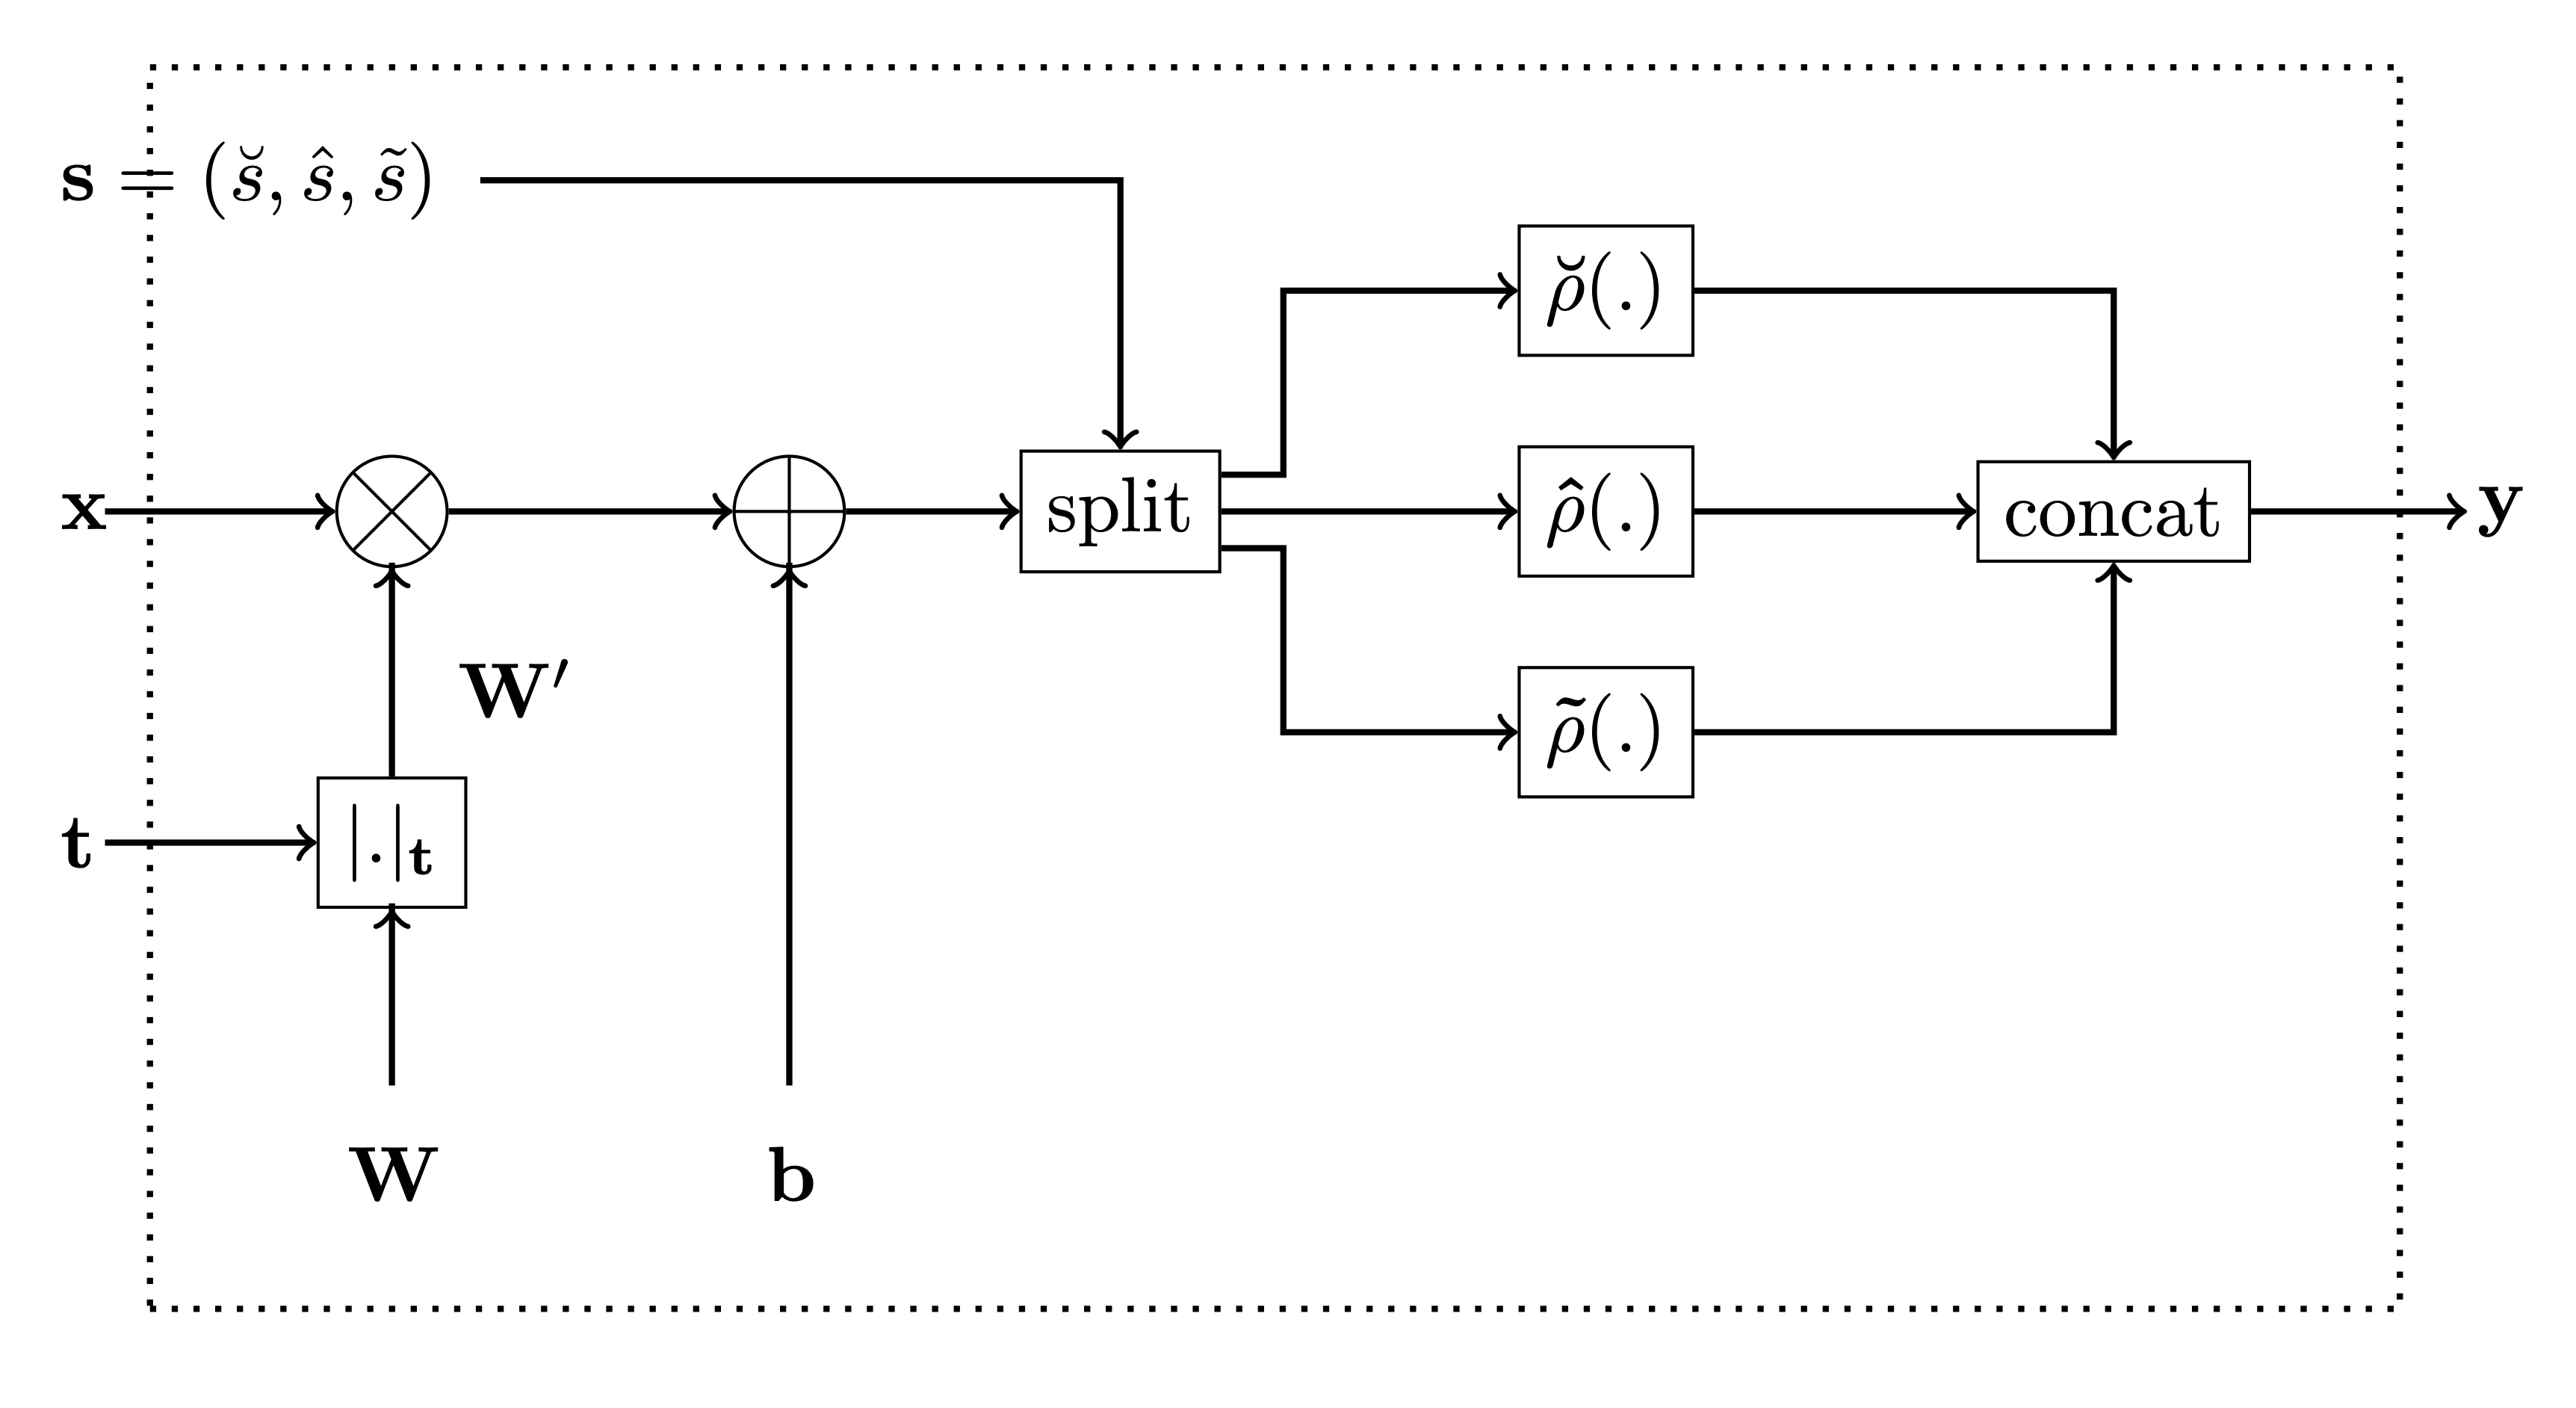

In [ ]:
#| export

class MonoDense(Dense):
    """Monotonic counterpart of the regular Dense Layer of tf.keras"""

    def __init__(
        self,
        units: int,
        *,
        activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
        monotonicity_indicator: ArrayLike = 1,
        is_convex: bool = False,
        is_concave: bool = False,
        activation_weights: Tuple[float, float, float] = (7.0, 7.0, 2.0),
        **kwargs: Dict[str, Any],
    ):
        """Constructs a new MonoDense instance.

        Params:
            units: Positive integer, dimensionality of the output space.
            activation: Activation function to use, it is assumed to be convex monotonically
                increasing function such as "relu" or "elu"
            monotonicity_indicator: Vector to indicate which of the inputs are monotonically increasing or
                monotonically decreasing or non-monotonic. Has value 1 for monotonically increasing,
                -1 for monotonically decreasing and 0 for non-monotonic.
            is_convex: convex if set to True
            is_concave: concave if set to True
            activation_weights: relative weights for each type of activation, the default is (1.0, 1.0, 1.0).
                Ignored if is_convex or is_concave is set to True
            **kwargs: passed as kwargs to the constructor of `Dense`

        Raise:
            ValueError:
                - if both **is_concave** and **is_convex** are set to **True**, or
                - if any component of activation_weights is negative or there is not exactly three components
        """
        if is_convex and is_concave:
            raise ValueError(
                "The model cannot be set to be both convex and concave (only linear functions are both)."
            )

        if len(activation_weights) != 3:
            raise ValueError(
                f"There must be exactly three components of activation_weights, but we have this instead: {activation_weights}."
            )

        if (np.array(activation_weights) < 0).any():
            raise ValueError(
                f"Values of activation_weights must be non-negative, but we have this instead: {activation_weights}."
            )

        super(MonoDense, self).__init__(units=units, activation=None, **kwargs)

        self.units = units
        self.org_activation = activation
        self.activation_weights = activation_weights
        self.monotonicity_indicator = monotonicity_indicator
        self.is_convex = is_convex
        self.is_concave = is_concave

        (
            self.convex_activation,
            self.concave_activation,
            self.saturated_activation,
        ) = get_activation_functions(self.org_activation)

    def build(self, input_shape: Tuple, *args: List[Any], **kwargs: Dict[str, Any]) -> None:
        """Build

        Args:
            input_shape: input tensor
            args: positional arguments passed to Dense.build()
            kwargs: keyword arguments passed to Dense.build()
        """
        super(MonoDense, self).build(input_shape, *args, **kwargs)
        self.monotonicity_indicator = get_monotonicity_indicator(
            monotonicity_indicator=self.monotonicity_indicator,
            input_shape=input_shape,
            units=self.units,
        )
        

    def call(self, inputs: TensorLike) -> TensorLike:
        """Call

        Args:
            inputs: input tensor of shape (batch_size, ..., x_length)
            
        Returns:
            N-D tensor with shape: `(batch_size, ..., units)`.

        """
        # calculate W'*x+y after we replace the kernal according to monotonicity vector
        with replace_kernel_using_monotonicity_indicator(self, monotonicity_indicator=self.monotonicity_indicator):
            h = super(MonoDense, self).call(inputs)
        
        y = apply_activations(
            h,
            units=self.units,
            convex_activation=self.convex_activation,
            concave_activation=self.concave_activation,
            saturated_activation=self.saturated_activation,
            is_convex=self.is_convex,
            is_concave=self.is_concave,
            activation_weights=self.activation_weights,
        )

        return y
    
MonoDense.__module__ = "mono_dense_keras"

In [ ]:
units = 18
activation = "relu"
batch_size = 9
x_len = 11

x = np.random.default_rng(42).normal(size=(batch_size, x_len))

tf.keras.utils.set_random_seed(42)

for monotonicity_indicator in [[1]*4+[0]*4+[-1]*3, 1, np.ones((x_len,)), -1, -np.ones((x_len,))]:
    print("*"*120)    
    mono_layer = MonoDense(
        units=units,
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        activation_weights=(7, 7, 4),
    )
    print("input:")
    display_kernel(x)

    y = mono_layer(x)
    print(f"monotonicity_indicator = {monotonicity_indicator}")
    display_kernel(mono_layer.monotonicity_indicator)
    
    print("kernel:")
    with replace_kernel_using_monotonicity_indicator(
        mono_layer, mono_layer.monotonicity_indicator
    ):
        display_kernel(mono_layer.kernel)
        
    print("output:")
    display_kernel(y)
print("ok") 

In [ ]:
x = Input(shape=(5, 7, 8))

layer = MonoDense(
    units=12,
    activation=activation,
    monotonicity_indicator=[1]*3+[-1]*3+[0]*2,
    is_convex=False,
    is_concave=False,
)

y = layer(x)

model = Model(inputs=x, outputs=y)

model.summary()

display_kernel(layer.monotonicity_indicator)